In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
import random

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from scipy.stats import kstest, linregress
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from torch import nn, optim
from torch.nn import MSELoss, L1Loss, BCELoss, SmoothL1Loss
from torch.optim import AdamW, Adamax, RMSprop, Adadelta, Adagrad
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt

In [ ]:
def extract_data(dataset):
    dataset_xt = np.concatenate([dataset[s].values.reshape(-1, 375, 1) for s in ["S1", "S2", "S3", "S4"]], axis=-1)
    dataset_xt = dataset_xt.transpose(0, 2, 1)
    # print("CUTTING DATA")
    # dataset_xt = dataset_xt[:, :, 50:]

    #TODO: use first positive or first negative value instead?

    def first_nonzero(arr, axis, invalid_val=-1):
        mask = arr != 0
        return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

    leading_zeros = first_nonzero(dataset_xt, axis=2)/375.0
    #leading_zeros *= 1000000
    leading_zeros = leading_zeros.reshape(*leading_zeros.shape, 1).repeat(dataset_xt.shape[-1], axis=2)
    # interleave stack
    #dataset_xt = np.concatenate([dataset_xt, leading_zeros], axis=-1).reshape(dataset_xt.shape[0], 8, -1)
    #dataset_xt = np.concatenate([dataset_xt, leading_zeros], axis=1)

    return dataset_xt


def extract_labels():
    train_target = pd.read_csv("/content/drive/My Drive/Dacon_튜터/train_target.csv")
    dataset_y = np.concatenate([train_target[s].values.reshape(-1, 1) for s in ["X", "Y", "M", "V"]], axis=-1)
    return dataset_y

## EDA

Initial data exploration was performed for each sensor, and to gain more intuition about the data. In the end not much domain knowledge was used, only the pure raw waveforms. 

- But it was observed that the waves for each of the sensors was similar, which gave the idea of using weight sharing on each of the sensors in the CNN model


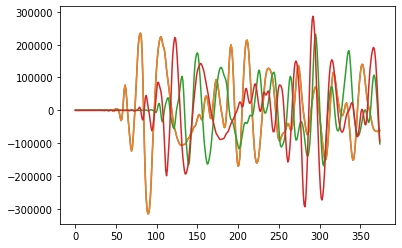

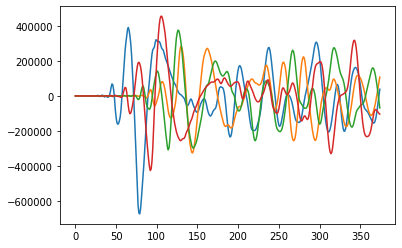

In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/Dacon_튜터/train_features.csv')
test_data = pd.read_csv("/content/drive/My Drive/Dacon_튜터/test_features.csv")


## X_train
## y_train
## X_test
## are what we are going to use
X_train = extract_data(train_data)
y_train = extract_labels()
X_test = extract_data(test_data)

plt.figure()
plt.plot(X_train[0].T)

plt.figure()
plt.plot(X_test[0].T)

In [ ]:
# 예시, (2800, 4, 375)
# Conv1D를 활용하기위해 (375, 4) -> (4, 375)로 transpose
ext = extract_data(pd.read_csv('/content/drive/My Drive/Dacon_튜터/train_features.csv'))
x1 = torch.Tensor(ext[0:32, :, :])
x1.shape

torch.Size([32, 4, 375])

In [ ]:
#import torch.nn.functional as F
# torch의 내장함수 troch.nn.function.initerpolate 를 이용하여 (4, 375) -> (4, 256) 으로. 
# https://gaussian37.github.io/dl-pytorch-snippets/#finterpolate%EC%99%80-nnupsample-1
F.interpolate(x1, size=256, mode='linear', align_corners=False).shape

torch.Size([32, 4, 256])

torch.Size([32, 4, 256])
torch.Size([128, 1, 256])
torch.Size([256])
torch.Size([256])


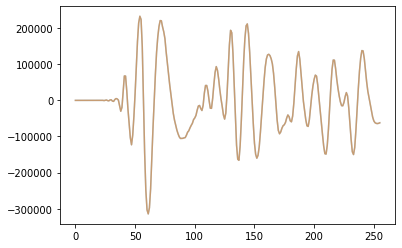

torch.Size([256])
torch.Size([256])


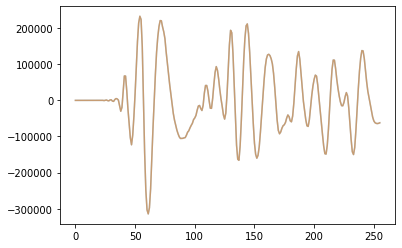

torch.Size([256])
torch.Size([256])


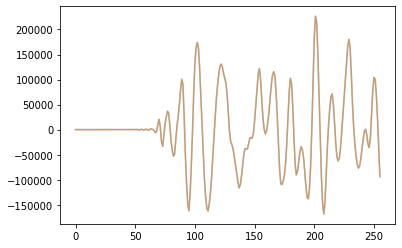

torch.Size([256])
torch.Size([256])


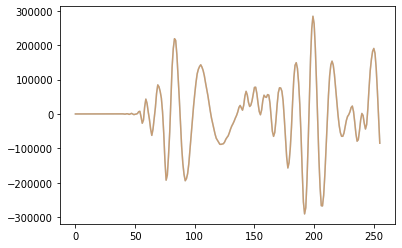

In [ ]:
# 배치사이즈 까지 고려하여 (32, 4, 256) -> (128, 1, 256) 으로 변환 
# 이부분이 핵심, 센서 4개간의 Sharing Weight!
# 항상 앞서 말했듯이 이 데이터에서 Conv을 사용할 때의 핵심은 Sharing Weight
# 기존 코드와의 차이점은, 기존 코드는 (375, 4, 1)에서 Conv2D를 이용하여 weight를 sharing 해줬다면 여기서는, 위와 같은 방법을 이용하여 weight를 sharing하고 있다. 
# 자세한건 뒤에서!
x1 = F.interpolate(x1, size=256, mode='linear', align_corners=False)
x2 = x1.reshape(-1, 1, x1.shape[2]) 
print(x1.shape)
print(x2.shape)
for i in range(0, 4):
  plt.figure()
  plt.plot(x1[0,i,:], alpha=0.5)
  print(x1[0,i,:].shape)
  plt.plot(x2[i,0,:], alpha=0.5)
  print(x2[i,0,:].shape)
  plt.show()

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Modeling  

No manual feature engineering was performed in the end.
- Although initial experiments were done using FFT and STFT, this was not used in the end
- FFT seemed to hit some limitations, so switching to raw wave form with 1D-CNN while more difficult to tune and train, ultimately gave better performance 
- (FFT는 몇 가지 한계에 부딪힌 것처럼 보였으므로 1D-CNN을 사용하여 원시 파형으로 전환하는 것은 조정 및 훈련이 더 어렵지만 궁극적으로 더 나은 성능을 제공했습니다.

- Autoencoding the wave was also attempted, but was too difficult to tune properly.

Final focus was on a 1D convnet on the raw waveform

In [ ]:
## target 마다 kernel size를 달리 해줌

class SingleConvAutoencoder(nn.Module):

    ## seed 고정
    def __init__(self, target_index=[3]):
        ## Class에 입력된 nn.Module의 class를 상속받아서 사용
        super().__init__()
        torch.random.manual_seed(0)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(0)
        random.seed(0)

        self.n_steps = 256
        self.target_index = target_index
        self.best_uniform = 1000000

        # 실질적으로 쓰이진 않아요.
        n_input = 4
        # V , kernel-size 7, n_embedding, 16
        # M, kernel-size 25, n_embedding, 64


        # mixup_mode 부분은 사용하지 않기에 모두 코드에서 모두 제외하였습니다.
        self.mixup_mode = False
        # target [[X, Y], [M], [V]] 마다 embedding size, kernel_size, epoch을 달리해줍니다.
        # embedding이란 용어를 쓴 것은 추후 설명하겠습니다. 
        if 2 in target_index:
            n_embedding = 32
            self.kernel_size = 65
            self.n_epochs = 330 # 240
            self.n_bins = 15
            self.mixup_mode = False
           
        if 3 in target_index:
            n_embedding = 1
            self.kernel_size = 7

            self.n_epochs = 90 #90 #100
            self.n_bins = 15
         
        if 1 in target_index or 0 in target_index:
            n_embedding = 32
            self.kernel_size = 35

            self.n_epochs = 210 #100
            self.n_bins = 20
          
        n_output = 4
        self.n_embedding = n_embedding

        # ----
        self.construct_conv_encoder(n_embedding)
        #self.fc0_out = nn.Linear(n_embedding, n_embedding)
        self.fc_out = nn.Linear(n_embedding, n_output)

        # ----
        self.device = "cuda:0"
        self.to(self.device)

        # standardize
        self.X_scaler = StandardScaler()
        self.y_scaler = MinMaxScaler(feature_range=(-1, 1))

    def construct_conv_encoder(self, n_embedding):
        # encoder
        # encoder 부분인데 기존의 코드와는 꽤 재밌는 차이점이 있습니다.
        # 기존의 코드는 앞서 말씀 드렸듯이 (32, 375, 4, 1)에서 단순히 Conv2D(3,1)을 통해 Weight를 sharing해줬습니다.
        # 여기선, 우선 Conv1D를 사용하기 위해 (32, 4, 375)로 변경후 (32, 4, 256)으로 다시 변경해줍니다.
        # 그 이후에 (32*4, 1, 256)으로 변환해주어 하나의 Conv1D가 모든 변수에 대해서 동일하게 적용하도록 해줍니다.
        # 하지만 배치가 32인데 (128, 1, 256)으로 됨으로서 이대로 결과가 나오는 것은 아니고
        # (128, 1, 256)을, (32, ?)로 embedding해주는 것입니다.
        # 그 이후에 (32 ?)에서 mlp를 통해 결과를 (32, 4)로 만들어 주는 것입니다.
        # 모든 변수에 대해서 하나의 Conv1D를 사용해주기 위해 encoder부분을 만들어 줬다고 보시면 됩니다. 
        # 이 부분은 forward부분에서 다시 알 수 있습니다. 
        kernel_size = self.kernel_size
        max_pool = 2
        n_feat = [16, 32, 64]
        padding = kernel_size//2
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=n_feat[0], kernel_size=kernel_size, padding=padding)
        self.conv1drop = nn.Dropout2d(p=0.)
        self.conv1b = nn.Conv1d(n_feat[0], n_feat[0], kernel_size=kernel_size, padding=padding)
        self.conv1bdrop = nn.Dropout2d(p=0.)
        self.pool1 = nn.MaxPool1d(max_pool)  # 190
        #self.pool1 = nn.FractionalMaxPool2d((1, 2), output_size=(1, 128))
        # self.pool1 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=13, stride=2, padding=6)
        self.conv2 = nn.Conv1d(n_feat[0], n_feat[1], kernel_size, padding=padding)
        self.conv2drop = nn.Dropout2d(p=0.)
        self.conv2b = nn.Conv1d( n_feat[1],  n_feat[1], kernel_size, padding=padding)
        self.conv2bdrop = nn.Dropout2d(p=0.)
        self.pool2 = nn.MaxPool1d(max_pool)  # 96
        # self.pool2 = nn.Conv1d(32, 32, 7, stride=2, padding=3)
        self.conv3 = nn.Conv1d( n_feat[1],  n_feat[2], kernel_size, padding=padding)
        self.conv3bdrop = nn.Dropout2d(p=0.)
        self.conv3b = nn.Conv1d( n_feat[2],  n_feat[2], kernel_size, padding=padding)
        self.conv3drop = nn.Dropout2d(p=0.)
        n_flatten = n_feat[2] * (self.n_steps // max_pool**2)

        n_flatten1 = n_flatten
        # n_bottle = 96 * 64
        self.fc1 = nn.Linear(n_flatten1 * 4, n_embedding)
        self.fc1drop = nn.Dropout(p=0.)
        #self.fc1drop = nn.BatchNorm1d(num_features=n_embedding)
        self.fc2 = nn.Linear(n_embedding, n_embedding)
        #self.fc3 = nn.Linear(n_embedding, n_embedding)
        #self.construct_conv_decoder(n_embedding, n_flatten)

    def forward_encoder(self, x):

        ##Encoder##
        ###########

        # 기본적으로 torch의 forward는 배치 단위로 데이터를 입력받습니다.
        batch_size = x.shape[0]
        # interpolate를 통해 사이즈를 조정해줍니다.
        x = F.interpolate(x, size=self.n_steps, mode='linear', align_corners=False)

        # sharing weight를 해주기 이해 (32, 4, 256) -> (128, 1, 256)으로 조정합니다.
        x = x.reshape(-1, 1, x.shape[2])  # NOTE: share weights!
        print("input_shape : " +  str(x.shape))

        # 앞서 정의했던 Conv1D 등을 순서에 맞게 입력!        
        x = self.pool1(self.conv1bdrop(F.relu(self.conv1b(self.conv1drop(F.relu(self.conv1(x)))))))
        x = self.pool2(self.conv2bdrop(F.relu(self.conv2b(self.conv2drop(F.relu(self.conv2(x)))))))
        x = self.conv3bdrop(F.relu(self.conv3b(self.conv3drop(F.relu(self.conv3(x))))))
        
        x = x.view(batch_size, -1)
        print("after conv shape : " + str(x.shape))
        # (32, n_flatten * 4)


        x = self.fc1(x)
        if self.n_embedding>1:
            x = F.relu(x)
            x = F.relu(self.fc2(x))
        
        ##Encoder##
        ###########
        return x

    def forward(self, x, alphas=None):
        # 기본적으로 배치 단위로 입력이 들어온다.
        batch_size = x.shape[0]
        # ---
        x = self.forward_encoder(x)
        print(x.shape)
        embedding = x

        # alpha = None으로 실행중.
        if alphas is not None:
            # embedding per A B C
            embedding_abc = embedding.view(batch_size // 3, 3, -1)
            # mixing
            embedding_alpha = embedding_abc[:, [0, 1, 2]] * alphas + embedding_abc[:, [1, 1, 1]].detach() * (1 - alphas)
            embedding = embedding_alpha.view(batch_size, -1)

        x = embedding
        x = self.fc_out(x)
        y_predictor = x
        return y_predictor


    def _X_transform(self, X):
        print("_X_transform")
        return self.X_scaler.transform(X.reshape(-1, 1)).reshape(X.shape).astype(np.float32)
        # if 2 in self.target_index or 3 in self.target_index:
        #     transformed = self.X_scaler.transform(X.transpose(0, 2, 1).reshape(-1, X.shape[1])).astype(np.float32)
        #     transformed = transformed.reshape(X.shape[0], X.shape[2], X.shape[1])
        #     transformed = transformed.transpose(0, 2, 1)
        #     return transformed
        # else:
        #     return self.X_scaler.transform(X.reshape(-1, 1)).reshape(X.shape).astype(np.float32)

    def _X_fit(self, X):
        print("_X_fit")
        self.X_scaler.fit(X.reshape(-1, 1))
        return
        # if 2 in self.target_index or 3 in self.target_index:
        #     self.X_scaler.fit(X.transpose(0, 2, 1).reshape(-1, X.shape[1]))
        # else:
        #     self.X_scaler.fit(X.reshape(-1, 1))

    def _y_transform(self, y):
        print("_y_transform")
        return self.y_scaler.transform(y)

    
    def fit(self, X_train_pred, y_train_pred, X_test, X_val_pred=None, y_val_pred=None):
        print("fit")
        target_index = self.target_index
        # standardize first on all data 
        X_train_rec = np.concatenate([X_train_pred, X_test], axis=0)
        self._X_fit(X_train_rec) # just scaling
        # full_set = self._X_transform(X_train_rec)
        # full_set2 = self._X_transform(X_test)
        # plt.scatter(np.arange(full_set.shape[0]), np.mean(full_set, axis=-1)[:, 0])
        # plt.scatter(np.arange(full_set2.shape[0]), np.mean(full_set2, axis=-1)[:, 0])
        # plt.show()

        # ---- train pred ----
        # fit y scaler
        self.y_scaler.fit(y_train_pred)
        X_train_pred = self._X_transform(X_train_pred)
        y_train_pred = self._y_transform(y_train_pred)
        print(X_train_pred.shape)

        dataloader_train_pred = DataLoader(TensorDataset(torch.Tensor(X_train_pred), torch.Tensor(y_train_pred)), batch_size=32, shuffle=True)
        if X_val_pred is not None:
            X_val_pred = self._X_transform(X_val_pred)
            y_val_pred = self._y_transform(y_val_pred)
            dataloader_val_pred = DataLoader(TensorDataset(torch.Tensor(X_val_pred), torch.Tensor(y_val_pred)), batch_size=32, shuffle=True)

        #optimizer = optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        if 2 in self.target_index:
            optimizer = optim.Adam(self.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-8, amsgrad=True)  #
            #optimizer = AdamW(self.parameters(), lr=0.00001, weight_decay=1e-2)
        if 3 in self.target_index:
            optimizer = optim.Adam(self.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-8, amsgrad=False)  #
            #optimizer = AdamW(self.parameters(), lr=0.00001, amsgrad=False, weight_decay=5e-2)
        if 0 in self.target_index or 1 in self.target_index:
            #optimizer = optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
            optimizer = optim.Adam(self.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, amsgrad=False) #
            #optimizer = AdamW(self.parameters(), lr=0.001, amsgrad=True, weight_decay=1e-2)

        plt.figure()
        min_loss = 100000
        save_path = "target_"+str(target_index[0]) +".pt"
        for e in range(self.n_epochs + 1):
            self.train()
            loss = self._run_epoch(e, dataloader_train_pred, target_index=target_index, optimizer=optimizer)
            #self.scheduler.step()
            # force uniformity
            uniformity_forced = -1
            if len(y_train_pred) > 700 and False:
                loss_uniformity = self.force_uniformity(X_test, np.min(y_train_pred[:, target_index]), np.max(y_train_pred[:, target_index]), optimizer=optimizer)
                #loss_uniformity2 = self.force_uniformity(X_test, np.min(y_train_pred[:, target_index]), np.max(y_train_pred[:, target_index]), slope=True, optimizer=optimizer)
                #loss_uniformity, uniformity_forced = self.force_uniformity(X_test, np.min(y_train_pred[:, target_index]), np.max(y_train_pred[:, target_index]), optimizer=None)
                print(e, "Loss Train", e, loss, loss_uniformity)
            else:
                print(e, "Loss Train", e, loss)
            # evaluate
            n_e = 10 if len(y_train_pred) > 2000 else 50
            if e %n_e==0 and y_val_pred is not None:
                self.eval()
                loss = self._run_epoch(e, dataloader_train_pred, target_index=target_index, optimizer=None)
                print(e, "-> Loss Train", e, loss)
                # if loss["pred"] < min_loss:
                #     print("->New min loss", min_loss, loss["pred"])
                #     min_loss = loss["pred"]

                # train and val loss
                loss = self._run_epoch(e, dataloader_val_pred, target_index=target_index, optimizer=None)
                print(e, "-> Loss Val", e, loss)

                loss = self.evaluate(X_val_pred, y_val_pred, transform=False)
                print(e, "-> Loss Val", e, loss)
                # -- save --
                th = 0.001
                if loss < th and e > 0:
                    self.save_test(X_test, target_index)

    ## 이 부분에서 self(input, alpha)들어가서 pred_output -> joint_loss -> joint_loss.backward()
    def _run_epoch(self, e, dataloader_pred, target_index, optimizer=None, callback=None):
        print("_run_epoch")
        criterion = L1Loss()
        running_loss = {"pred": 0.0, "embedding": 0.0, "rec": 0.0, "embedding_rec": 0.0, "rec_embedding_rec": 0.0}
        running_loss = {"pred": 0.0}
        counter = 0
        for i, data in enumerate(dataloader_pred, 0):
            # get the inputs; data is a list of [inputs, labels]
            pred_inputs_abc, pred_target_abc = data[0].to(self.device), data[1].to(self.device)

            if optimizer is not None:
                # zero the parameter gradients
                optimizer.zero_grad()

            alphas = None

            #####################
            ###### forward ######
            #####################
            pred_output = self(pred_inputs_abc, alphas=alphas)
            print(pred_output.shape)

            # complex loss, target should depend on mixup rate of A C
            # shape: batch_size, triplets, x
            # -- mean embedding loss, 0.5A + 0.5C = B  -> mean embedding same (even if we take alphas?) --
            #pred_embedding_abc = pred_embedding.view(pred_embedding.shape[0]//3, 3, -1)
            #pred_embedding_loss = criterion(torch.mean(pred_embedding_abc[:, [0, 2]], dim=1), pred_embedding_abc[:, 1].detach())
            # -- label mixing loss --
            # alphas shape: batch_size//3, 1, 1
            pred_target_loss = criterion(pred_output[:, target_index], pred_target_abc[:, target_index].detach())

            if optimizer is not None:
                joint_loss = pred_target_loss
                joint_loss.backward()
                #torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=5)
                optimizer.step()
            # print statistics
            running_loss["pred"] += pred_target_loss.item()
            #running_loss["embedding"] += pred_embedding_loss.item()
            counter += 1
            if callback is not None:
                callback()

        for key in running_loss.keys():
            running_loss[key]/=counter

        # # visualize
        # if e %10 == 0:
        #     plt.clf()
            #plt.plot(inputs_orig[0, 0].detach().cpu().numpy())
            #plt.plot(rec_inputs[0, 0].detach().cpu().numpy(), c="C5", alpha=0.5)
            #plt.plot(inputs[0, 0].detach().cpu().numpy(), c="C6", alpha=0.5)
            #plt.plot(rec_output[0, 0].detach().cpu().numpy(), c="C1")
            #plt.pause(0.01 if optimizer is not None else 0.1)

        return running_loss

    def evaluate(self, X, y, transform=False):
        print("evaluate")
        self.eval()
        criterion = MSELoss()
        y_pred = self.predict(X, transform=transform)
        loss = criterion(torch.from_numpy(y[:, self.target_index]).to(self.device), y_pred[:, self.target_index])
        y_pred_inv = self.y_scaler.inverse_transform(y_pred.detach().cpu().numpy())
        y_inv = self.y_scaler.inverse_transform(y)
        losses = 0
        for i in self.target_index:
            #print("--> prediction", y_pred[0, i].item(), y_pred_inv[0, i], y_inv[0, i])
            loss_i = E_partial(y_inv[:, i], y_pred_inv[:, i], i)
            print("--> partial E", i, loss_i)
            losses += loss_i
        losses/=len(self.target_index)
        # plt.clf()
        # plt.hist(y_pred_inv[:, self.target_index])
        # plt.pause(1)
        return losses

    def save_test(self, X, target_index):
        print("save_test")
        pred = self.predict(X, transform=True)

        plt.clf()
        plt.hist(pred.detach().cpu().numpy()[:, target_index], bins=self.n_bins)
        plt.pause(0.1)

        pred = pred.clamp(-1, 1)
        #uniformity = kstest(pred[:, target_index].detach().cpu().numpy(), "uniform")[0]
        #TODO: calculate at each training label using uniques, the count of labels in that bin
        #TODO: mean count of peaks should equal mean of in between peaks
        uniformity = calc_uniformity(pred.detach().cpu().numpy(), target_index, self.n_bins)
        print("Uniformity", uniformity)

        y_pred_inv = self.y_scaler.inverse_transform(pred.detach().cpu().numpy())

        y_pred_inv_qt = np.copy(y_pred_inv)

        for i in range(y_pred_inv.shape[1]):
            qt = QuantileTransformer(n_quantiles=int(15 * 8), random_state=0, output_distribution='uniform')
            sc = MinMaxScaler()
            y_pred_inv_qt[:, i] = sc.inverse_transform(qt.fit_transform(sc.fit_transform(y_pred_inv[:, i].reshape(-1, 1)))).ravel()

        # save
        y_pred_inv = y_pred_inv[:, target_index]
        df = pd.DataFrame(data=y_pred_inv.reshape(y_pred_inv.shape[0], -1), columns=target_index)
        y_pred_inv_qt = y_pred_inv_qt[:, target_index]
        df_qt = pd.DataFrame(data=y_pred_inv_qt.reshape(y_pred_inv_qt.shape[0], -1), columns=target_index)

        if uniformity <= self.best_uniform:
            self.best_uniform = uniformity
            print("New best uniform", uniformity)
        print("-> saving test predictions")
        df.to_csv("prediction_"+str(target_index)+".csv")
        df_qt.to_csv("prediction_qt_" + str(target_index) + ".csv")


    def predict(self, X, transform=True):
        print("predict")
        self.eval()
        if transform:
            X = self._X_transform(X)
        X_pt = torch.from_numpy(X).to(self.device)
        output = self(X_pt)
        return output

    @staticmethod
    def load_model(save_path):
        print("load_model")
        model = torch.load(save_path)
        return model

In [ ]:
def E_partial(_t, _p, target_idx):
    if target_idx < 2:
        return np.mean(np.square(_t - _p) / 2e+04)
    else:
        return np.mean(np.square((_t - _p) / (_t + 1e-06)))

def calc_uniformity(prediction, target_index, n_bins):
    uniformity_loss = 0
    for tidx in target_index:
        prediction = prediction.clip(-1, 1)
        # take sorted values
        uniques = np.sort(prediction[:, tidx])
        linspace = np.linspace(-1, 1, num=len(uniques))
        #uniformity_loss = np.mean(np.abs(uniques-linspace))
        hist_pred = np.histogram(uniques, bins=n_bins, density=True)[0]
        # hist_lin = np.histogram(linspace, bins=n_bins, density=True)[0]
        # plt.hist(uniques, bins=n_bins, density=True, alpha=0.5)
        # plt.hist(linspace, bins=n_bins, density=True, alpha=0.5)
        # plt.hlines(np.mean(hist_pred), -1, 1)
        # plt.show()
        #uniformity_loss += np.mean(np.abs(hist_pred-hist_lin)**2)
        uniformity_loss += np.std(hist_pred)
    uniformity_loss/=len(target_index)
    return uniformity_loss

In [ ]:
def validation_idx():
    # only take every second label in training set, resulting in 288 training points
    train_target = pd.read_csv('/content/drive/My Drive/Dacon_튜터/train_target.csv')
    size = train_target.shape[0]
    comb = {'X': np.unique(train_target["X"].values)[1:-1:2],
            'Y': np.unique(train_target["Y"].values)[1:-1:2],
            'M': np.unique(train_target["M"].values)[1:-1:2],
            'V': np.unique(train_target["V"].values)[1:-1:2]}

    for par, values in comb.items():
        train_target = train_target[~train_target[par].isin(values)]

    train_idx = train_target.id.tolist()
    test_idx = set(range(size)) - set(train_idx)
    return np.array(train_idx), np.array(list(test_idx))

In [ ]:
if __name__ == '__main__':
    train_data = pd.read_csv('/content/drive/My Drive/Dacon_튜터/train_features.csv')
    test_data = pd.read_csv('/content/drive/My Drive/Dacon_튜터/test_features.csv')

    X_train = extract_data(train_data)
    X_test = extract_data(test_data)

    # prediction target
    y_train = extract_labels()
    train_idx, val_idx = validation_idx()
    X_val_pred, y_val_pred = X_train[val_idx], y_train[val_idx]
    X_train_pred, y_train_pred = X_train[train_idx], y_train[train_idx]
    print(len(X_val_pred), len(X_train_pred))

    # targets to predict for each individual model
    target_idxs = [[0, 1], [2], [3]]
    for tid in target_idxs:
        # construct model
        model = SingleConvAutoencoder(target_index=tid)
        print(model)
        [print(param.shape) for param in model.parameters()]
        #model.fit(X_train_pred, y_train_pred, X_test, X_val_pred, y_val_pred)
        print("fitting full model")
        model.fit(X_train, y_train, X_test, X_val_pred, y_val_pred)

    # load each separate file and save to single file
    print("Saving Final Submission File")
    df_save = pd.DataFrame(columns=["X", "Y", "M", "V"])
    df_pred = pd.concat([pd.read_csv("prediction_qt_" + str(tid) + ".csv").drop(columns='Unnamed: 0', axis=1) for tid in target_idxs], axis=1)
    
    df_save["id"] = np.arange(2800, 3500)
    df_save["X"] = df_pred["0"]
    df_save["Y"] = df_pred["1"]
    df_save["M"] = df_pred["2"]
    df_save["V"] = df_pred["3"]
    df_save.to_csv("submission_v5_qt.csv", columns=["id", "X", "Y", "M", "V"], index=False)

2512 288
SingleConvAutoencoder(
  (conv1): Conv1d(1, 16, kernel_size=(35,), stride=(1,), padding=(17,))
  (conv1drop): Dropout2d(p=0.0, inplace=False)
  (conv1b): Conv1d(16, 16, kernel_size=(35,), stride=(1,), padding=(17,))
  (conv1bdrop): Dropout2d(p=0.0, inplace=False)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(35,), stride=(1,), padding=(17,))
  (conv2drop): Dropout2d(p=0.0, inplace=False)
  (conv2b): Conv1d(32, 32, kernel_size=(35,), stride=(1,), padding=(17,))
  (conv2bdrop): Dropout2d(p=0.0, inplace=False)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(35,), stride=(1,), padding=(17,))
  (conv3bdrop): Dropout2d(p=0.0, inplace=False)
  (conv3b): Conv1d(64, 64, kernel_size=(35,), stride=(1,), padding=(17,))
  (conv3drop): Dropout2d(p=0.0, inplace=False)
  (fc1): Linear(in_features=16384, out_features=32, bias=True)
  (fc1dr

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>